In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

Found GPU at: /device:GPU:0


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

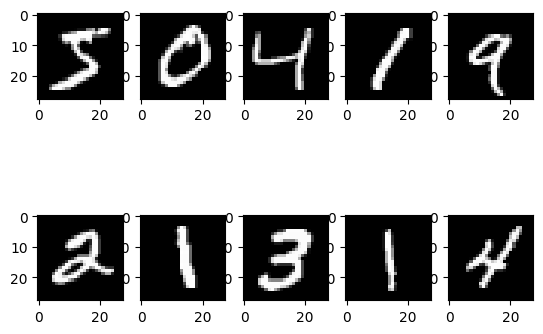

In [3]:
# on charge le dataset
(img_train, _), (_,_) = keras.datasets.mnist.load_data()
img_train = img_train / 255.0
dataset = np.expand_dims(img_train, axis=-1)
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(img_train[i], cmap='gray')
plt.show()

In [4]:
discriminator_model = keras.Sequential()
discriminator_model.add(keras.layers.Conv2D(64, (3,3),input_shape=(28,28,1),
  strides=(2, 2), padding='same'))
discriminator_model.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator_model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
discriminator_model.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator_model.add(keras.layers.Flatten())
discriminator_model.add(keras.layers.Dense(1, activation='sigmoid'))

discriminator_model.summary()

loss=keras.losses.BinaryCrossentropy()
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_model.compile(loss=loss, optimizer=optim, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           3,137 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,705 (159.00 KB)

 Trainable params: 40,705 (159.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# espace latent à 100 dimensions
latent_dim=100

generator_model = keras.Sequential()

# on génère une image de 7x7 pixels avec une profondeur de 128
n_nodes = 128 * 7 * 7
generator_model.add(keras.layers.Dense(n_nodes, input_dim=100))
generator_model.add(keras.layers.LeakyReLU(alpha=0.2))
generator_model.add(keras.layers.Reshape((7, 7, 128)))

# convolution transposée et unpooling (7x7 -> 14x14)   ↓ unpooling
generator_model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator_model.add(keras.layers.LeakyReLU(alpha=0.2))

# convolution transposée et unpooling (14x14 -> 28x28)    ↓ unpooling
generator_model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator_model.add(keras.layers.LeakyReLU(alpha=0.2))

# convolution unique pour réduire la profondeur à 1
generator_model.add(keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))

generator_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 6272)                │         633,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,164,289 (4.44 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# connect them
gan_model = keras.Sequential()
# add generator
gan_model.add(generator_model)
# add the discriminator
gan_model.add(discriminator_model)

loss=keras.losses.BinaryCrossentropy()
optim = keras.optimizers.Adam(0.0002, beta_1=0.5)
gan_model.compile(loss=loss, optimizer=optim)

gan_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 28, 28, 1)           │       1,164,289 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │          40,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,204,994 (4.60 MB)

 Trainable params: 1,204,994 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

*fonction pour générer une série de vecteurs aléatoires d’une taille donnée*

In [7]:
# échantillon de vecteurs de l'espace latent
def generate_latent_vectors(latent_dim, n_samples):
  input_vectors = np.random.randn(latent_dim * n_samples)
  input_vectors = input_vectors.reshape(n_samples, latent_dim)
  return input_vectors

*fonction pour récupérer un ensemble aléatoire d’images du dataset*

In [8]:
# échantillon d'images réelles
def generate_real_samples(dataset, n_samples):
  rand = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[rand]
  # vecteur de 1 pour désigner les vraies images
  y = np.ones((n_samples, 1))
  return X, y

*fonction pour générer un ensemble de ‘fausses’ images*

In [9]:
#  échantillon d'images générées par le réseau générateur
def generate_fake_samples(g_model, latent_dim, n_samples):
  input_vectors = generate_latent_vectors(latent_dim, n_samples)
  X = g_model.predict(input_vectors)
  y = np.zeros((n_samples, 1))
  return X, y

*fonction pour enregistrer un
échantillon de 100 images sous forme d’un fichier png*

In [10]:
fake_sample_latent=generate_latent_vectors(latent_dim, 100)
# fonction pour enregistrer un échantillon d'images générées au format png
def save_image(epoch, n=10):

  # on génère les images depuis l'échantillon de vecteur
  sample_fakes=generator_model.predict(fake_sample_latent)

  # on assemble l'image
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(sample_fakes[i, :, :, 0], cmap='gray_r')
  # on enregistre l'image
  filename = '/tmp/generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()

**Votre session a planté après avoir utilisé toute la mémoire RAM disponible.**

In [11]:
n_epochs=10
n_batch=256
batch_per_epoch = int(dataset.shape[0] / n_batch)
# pour chaque epoch
for i in range(1):
  # pour chaque batch
  for j in range(batch_per_epoch):

    # étape 1 : on entraine le réseau discriminateur

    # on créé un batch d'échantillon à partir d'images réelles et générées
    X_real, y_real = generate_real_samples(dataset, int(n_batch/2))
    X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, int(n_batch/2))
    X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

    # on entraine le réseau discriminateur
    discriminator_model.trainable=True
    discriminator_model.train_on_batch(X, y)

    # second batch pour entrainer le discriminateur
    X_real, y_real = generate_real_samples(dataset, int(n_batch/2))
    X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, int(n_batch/2))
    X, yc = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
    d_loss, _ = discriminator_model.train_on_batch(X, y)

    # étape 2 : on entraine le GAN entier (discriminateur figé)

    # on créé un batch d'échantillons à partir d'images générées
    X_gan = generate_latent_vectors(latent_dim, n_batch)
    y_gan = np.ones((n_batch, 1))

    # on fige le discriminateur et on effectue l'apprentissage
    discriminator_model.trainable=False
    g_loss = gan_model.train_on_batch(X_gan, y_gan)

    print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss, np.mean(g_loss)) )

  # à chaque fin d'epoch, on enregistre une image d'échantillons
  save_image(2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
>1, 1/234, d=0.670, g=0.666
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


>1, 2/234, d=0.661, g=0.666
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>1, 3/234, d=0.652, g=0.671
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>1, 4/234, d=0.644, g=0.672
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>1, 5/234, d=0.635, g=0.674
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>1, 6/234, d=0.627, g=0.676
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>1, 7/234, d=0.618, g=0.676
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>1, 8/234, d=0.610, g=0.677
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>1, 9/234, d=0.602, g=0.677
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
>1, 10/234, d=0.594, g=0.677
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
>1, 11/234, d=0.586, g=0.677
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Charger et normaliser le dataset MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normaliser entre 0 et 1
x_train = np.expand_dims(x_train, axis=-1)  # Ajouter la dimension de canal pour les images grayscale

# Taille du batch
batch_size = 64

# Définition du générateur
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, input_dim=100, activation='relu'))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=1, padding='same', activation='sigmoid'))
    return model

# Définition du discriminateur
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Construire les modèles
generator = make_generator_model()
discriminator = make_discriminator_model()

# Compilations
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
gan = Sequential([generator, discriminator])
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Fonction pour entraîner le GAN
def train_gan(epochs, batch_size=64, save_interval=50):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Sélectionner un batch d'images réelles
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Générer un batch d'images fausses
        noise = np.random.normal(0, 1, (half_batch, 100))  # Générer des vecteurs aléatoires
        fake_images = generator.predict(noise)

        # Entraîner le discriminateur (images réelles = 1, images fausses = 0)
        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Entraîner le générateur (le discriminateur est figé)
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Afficher les progrès
        # Afficher les progrès
        if epoch % save_interval == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss}] [G loss: {g_loss}]")
            save_generated_images(epoch)


# Sauvegarder des images générées pour visualiser les progrès
def save_generated_images(epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images * 255.0
    generated_images = generated_images.astype('uint8')

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.close()

# Lancer l'entraînement
train_gan(epochs=10000, batch_size=64, save_interval=100)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
0/10000 [D loss: 0.7026033997535706] [G loss: [array(0.70485365, dtype=float32), array(0.70485365, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━